In [8]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import random


%matplotlib inline

In [14]:
test_img = Image.open('/Users/gg-5702/Documents/photofamille.jpg').convert('L')


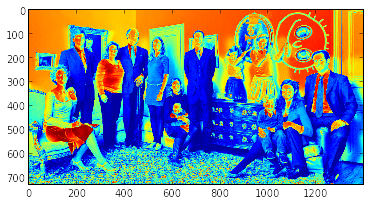

In [15]:
plt.imshow(np.asarray(test_img))

In [16]:
def rd_model(img):
    rd = random.random()
    return 0 if rd < 0.95 else 1

In [19]:
def sample_img(img, strides, chunk):
    """
    Generator. sample an image given the parameters
    param img : the image to sample
    param strides : tuple (sx, sy); step between two analyzed chunk
    param chunk : integer, size of a square returned
    return : x unstrided, y unstrided, and a sample of img of shape (chunk, chunk, 3), padding valid
    """
    for x in range(0, img.shape[0], strides[0]): 
        if x+chunk > img.shape[0]:
            break
        for y in range(0, img.shape[1], strides[1]):
            if y+chunk > img.shape[1]:
                break
            yield x//strides[0], y//strides[0], img[x:x+chunk, y:y+chunk]

def apply_model(img, scale, strides, padding, model):
    """
    analyze a whole image using a unique model (similar working than upgraded convolution)
    param img : PIL image representing the whole image to be analyzed
    param scale : float, in range [0;1], scaling applied to the image before analyzing
    param strides : tuple (sx, sy); step between two analyzed chunk
    param padding : doesn't affect analyzing right now
    param model : how to analyze the image. Input must be 36x36, output must be integer
    return: a list of nparrays of size (imgL*scale/stridex, imgl*scale/stridey) rounded to the floor,
            where each scale is decreased by 20% each time (if you begin with scale 1, you have : 
            [outs1, outs0.8, outs0.64, ...])
    """
    chunk = 36
    
    if int(img.size[0]*scale) <= chunk+strides[0] or int(img.size[1]*scale) <= chunk+strides[1]:
        return []
    img_cpy = img.resize((int(img.size[0]*scale), int(img.size[1]*scale)))
    img_as_arr = np.asarray(img_cpy)
    output = - np.ones((img_as_arr.shape[0]//strides[0], img_as_arr.shape[1]//strides[1]))
    sampler = sample_img(img_as_arr, strides, chunk)
    x = 0
    y = 0
    for x, y, sample in sampler:
        output[x, y] = rd_model(sample)
        
    output = [(output[:x, :y], scale)]
    output += apply_model(img, scale*0.8, strides, padding, model)
    return output

In [22]:
out = apply_model(test_img, 1, (1, 1), None, None)
for o, s in out:
    print(o.shape)
    print(s)

(694, 1364)
1
(548, 1084)
0.8
(431, 860)
0.64
(337, 680)
0.512
(263, 537)
0.4096
(203, 422)
0.32768
(155, 331)
0.262144
(117, 257)
0.2097152
(86, 198)
0.16777216
(61, 151)
0.134217728
(42, 114)
0.1073741824
(26, 84)
0.08589934592
(14, 60)
0.068719476736
(4, 40)
0.0549755813888


In [23]:
t2 = test_img.copy()

In [24]:
def draw_on_image(img, matched, strides, scale):
    chunk = 36
    cpy = img.copy()
    cpy = cpy.resize((int(img.size[0]*scale), int(img.size[1]*scale)))
    draw = ImageDraw.Draw(cpy)
    for y, line in enumerate(matched):
        for x, value in enumerate(line):
            if value == 1:
                draw.rectangle([x*strides[0], y*strides[1],
                               x*strides[0]+chunk, y*strides[1]+chunk],
                               fill=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), 255))
    cpy = cpy.resize(img.size)
    
    return cpy

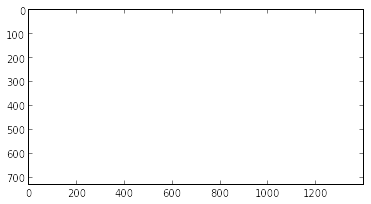

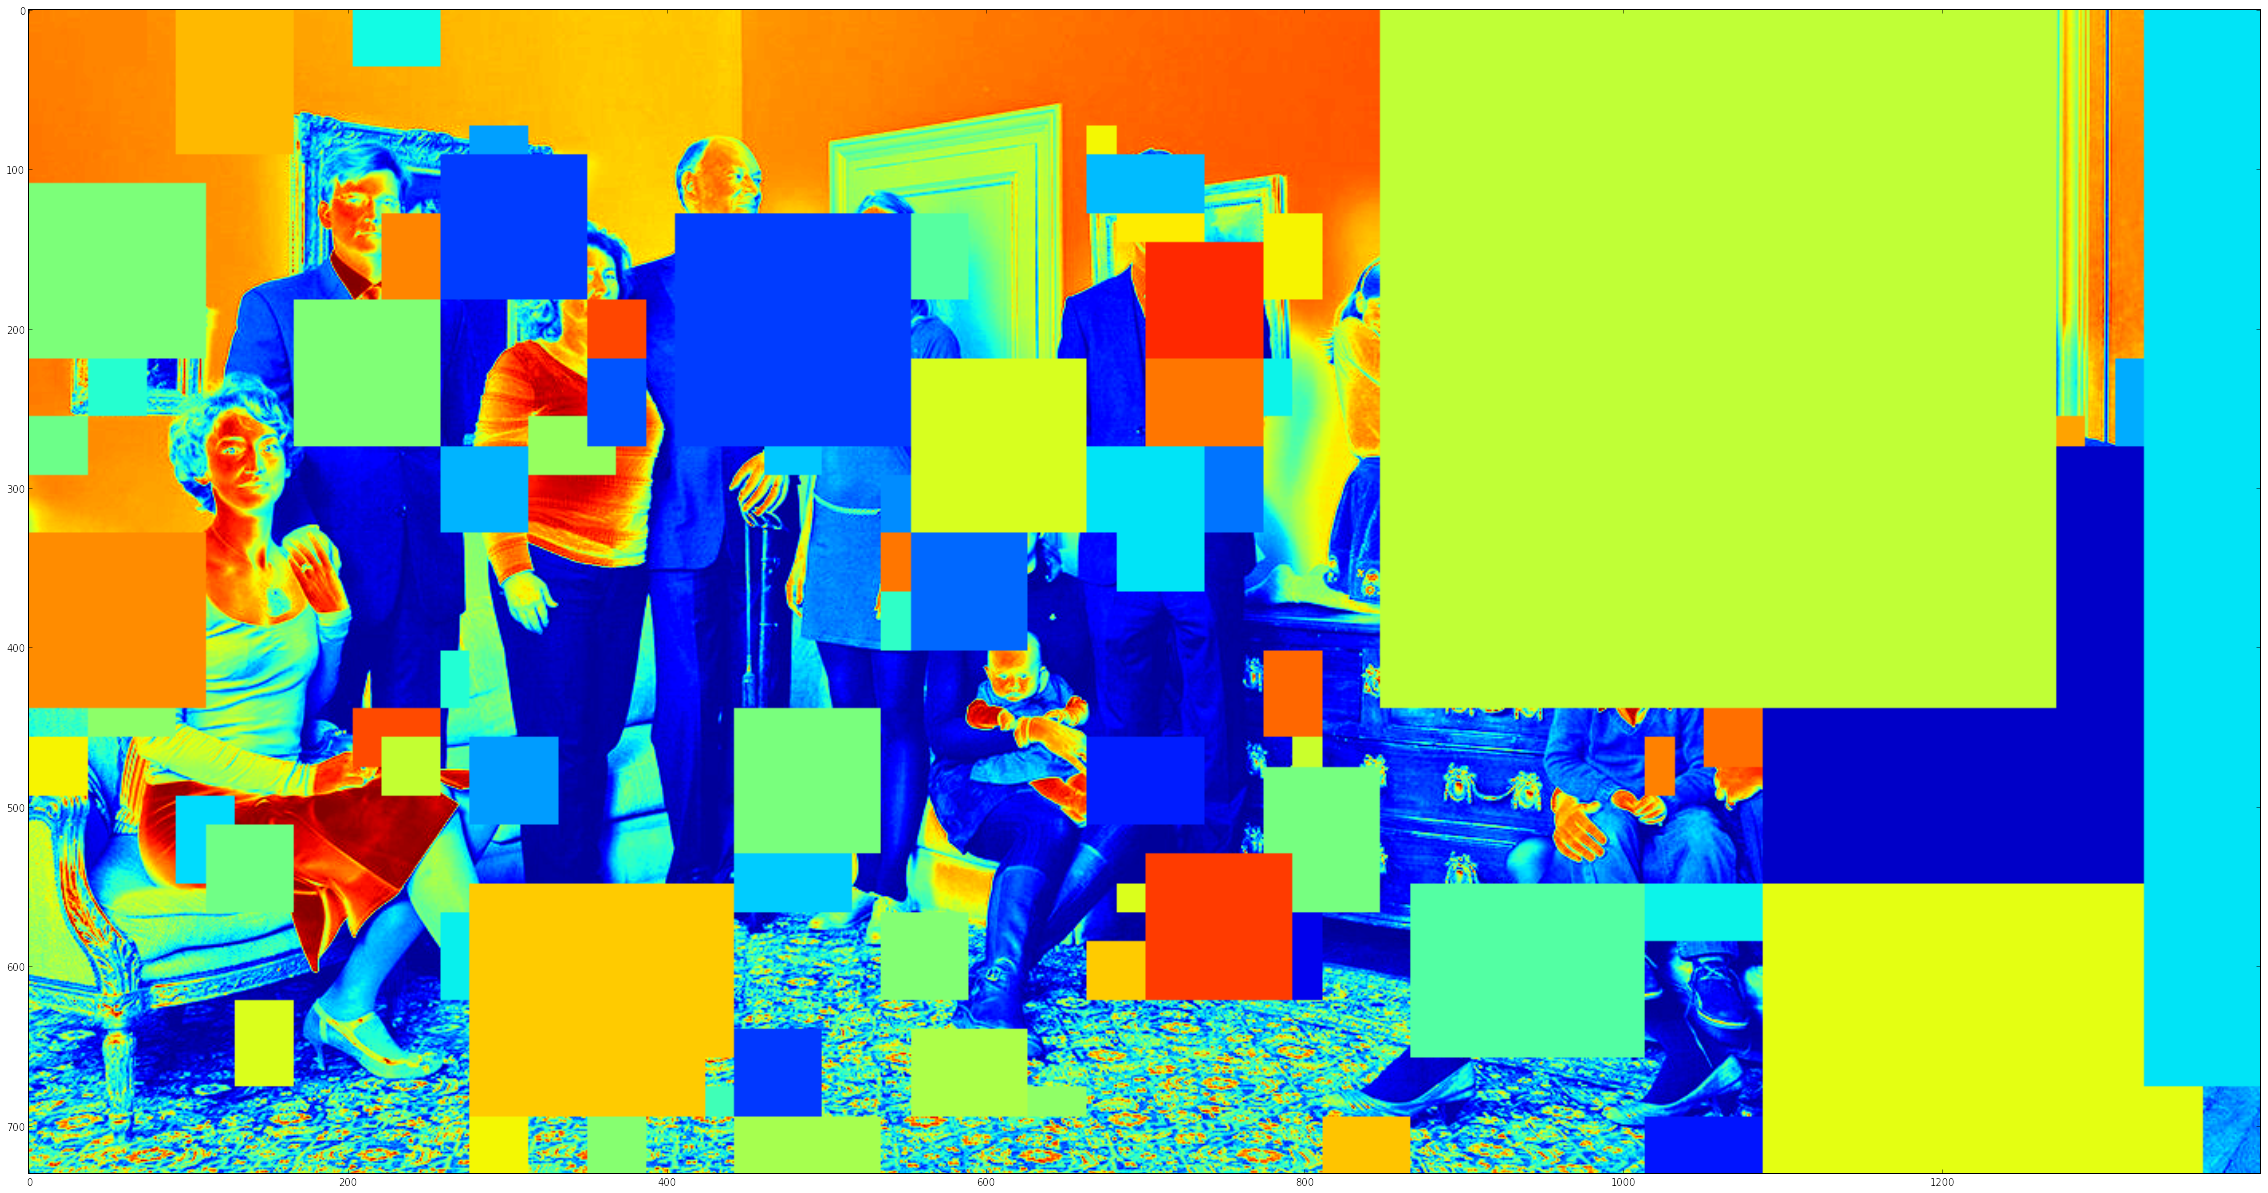

In [25]:
blank = Image.new(mode='RGBA', size=t2.size, color=(0, 0, 0, 0))
plt.imshow(np.asarray(blank))
plt.show()
for o, s in out:
    blank = draw_on_image(blank, o, (36, 36), s)

t2.paste(blank, (0, 0), mask=blank)
plt.figure(figsize=(40, 40))
plt.imshow(np.asarray(t2))